In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import optax
from functools import partial
from typing import Callable
import time

from history import History

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from cmap import Colormap
cmap = Colormap('crameri:batlow').to_mpl()

In [2]:
from problems import Poisson1D
problem = Poisson1D()

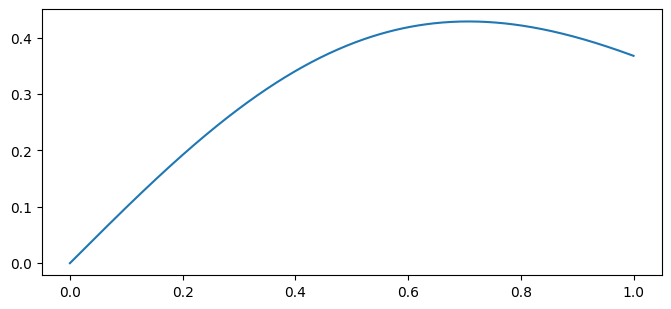

In [3]:
X, u_solution = problem.exact_solution(nx=512)

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")
ax_exact = ax.plot(X, u_solution)

# Optimiser

In [109]:
class ExpLevenbergMarquardt:
    """
    Levenberg-Marquardt optimiser.
    """

    def __init__(
        self,
        lambda_iterations: int = 5,
        lambda_size: int = 100,
    ):
        self.lambda_iterations = lambda_iterations
        self.lambda_size = lambda_size


    def init(self, params: eqx.Module):
        """Initializes the optimizer state with the initial damping factor."""
        # return {'lambda': self.init_lambda}
        return {
            'best_lambda': jnp.array(0.0),
            'iterations_left': jnp.array(0, dtype=jnp.int32)
        }

    def update(
        self,
        params: eqx.Module,
        state: optax.OptState,
        residual_fn: Callable[[eqx.Module], jax.Array]
    ):
        def search_and_update(p, s):
            """Phase 1: Search for the best lambda and apply the first update."""
            params_flat, unflatten = jax.flatten_util.ravel_pytree(p)

            def flat_residual_fn(p_flat):
                return residual_fn(unflatten(p_flat))

            residuals = residual_fn(p)
            current_loss = jnp.mean(residuals**2)

            J = jax.jacfwd(flat_residual_fn)(params_flat)
            U, S, Vt = jnp.linalg.svd(J, full_matrices=False)
            Rhs = U.T @ residuals

            # Create a grid of lambda candidates to search over
            lambdas = jnp.logspace(jnp.log10(1e-3), jnp.log10(1e4), self.lambda_size)

            def evaluate_candidate(trial_lambda: jax.Array) -> tuple[jnp.array, jax.Array]:
                """Evaluates a single lambda candidate."""
                S_inv = S / (S**2 + trial_lambda)
                delta = -Vt.T @ jnp.diag(S_inv) @ Rhs
                trial_params = unflatten(params_flat + delta)
                trial_loss = jnp.mean(residual_fn(trial_params)**2)
                return trial_loss, delta

            # Vmap over all candidates to find all trial losses and corresponding deltas
            all_trial_losses, all_deltas = jax.vmap(evaluate_candidate)(lambdas)

            # Find the best candidate from the grid search
            best_idx = jnp.argmin(all_trial_losses)
            best_delta = all_deltas[best_idx]
            best_lambda = lambdas[best_idx]
            
            updates = unflatten(best_delta)
            
            # Set the new state: store the best lambda and reset the iteration counter.
            # We subtract 1 because we are using one iteration right now.
            new_state = {
                'best_lambda': best_lambda,
                'iterations_left': jnp.array(self.lambda_iterations - 1, dtype=jnp.int32)
            }

            metrics = {
                'loss': current_loss,
                'lambda': best_lambda,
                'singular_values': S,
                'search_direction_norm': jnp.linalg.norm(best_delta),
                'mode': jnp.array(1) # 1 for search mode
            }
            return current_loss, updates, new_state, metrics

        def fixed_step_update(p, s):
            """Phase 2: Use the existing best_lambda for a step."""
            params_flat, unflatten = jax.flatten_util.ravel_pytree(p)
            
            def flat_residual_fn(p_flat):
                return residual_fn(unflatten(p_flat))

            residuals = residual_fn(p)
            current_loss = jnp.mean(residuals**2)

            J = jax.jacfwd(flat_residual_fn)(params_flat)
            U, S, Vt = jnp.linalg.svd(J, full_matrices=False)
            Rhs = U.T @ residuals

            # Use the lambda stored in the state
            fixed_lambda = s['best_lambda']
            S_inv = S / (S**2 + fixed_lambda)
            delta = -Vt.T @ jnp.diag(S_inv) @ Rhs
            
            updates = unflatten(delta)
            
            # Decrement the counter for iterations left
            new_state = {
                'best_lambda': fixed_lambda,
                'iterations_left': s['iterations_left'] - 1
            }

            metrics = {
                'loss': current_loss,
                'lambda': fixed_lambda,
                'singular_values': S,
                'search_direction_norm': jnp.linalg.norm(delta),
                'mode': jnp.array(0) # 0 for fixed mode
            }
            return current_loss, updates, new_state, metrics

        # Use lax.cond to choose the execution path based on the counter.
        # This is the JAX-native way to do conditional execution inside a JIT-compiled function.
        return jax.lax.cond(
            state['iterations_left'] > 0,
            fixed_step_update, # operand for true
            search_and_update, # operand for false
            params,            # first argument to the chosen function
            state              # second argument to the chosen function
        )


# The train_step function remains largely the same, just passing state through.
@partial(jax.jit, static_argnums=(3, 4))
def train_step(params, static_parts, opt_state, optimiser, problem, collocation_points):
    """
    A single step of training.
    """
    def residual_fn_for_optimizer(p):
        rebuilt_model = eqx.combine(p, static_parts)
        return problem.physics_residual(problem.residual_fn, rebuilt_model, collocation_points)

    loss, updates, new_opt_state, metrics = optimiser.update(params, opt_state, residual_fn_for_optimizer)
    new_params = eqx.apply_updates(params, updates)
    
    return new_params, new_opt_state, loss, metrics

In [110]:
key = jax.random.PRNGKey(42)

# --- Hyperparameters ---
n_collocation_points = 2**12
layer_sizes = [1, 12, 12, 12, 12, 1]
# -----------------------

model_key, data_key = jax.random.split(key)
model = problem.FCN(model_key, layer_sizes)
params, static = eqx.partition(model, eqx.is_array)
history = History()
collocation_points = problem.get_collocation_points(n_collocation_points, seed=1)


optimiser = ExpLevenbergMarquardt(
    lambda_iterations=2,
    lambda_size=1000,
)
opt_state = optimiser.init(params)

start_time = time.monotonic()

print(f"Starting PINN training with {type(optimiser).__name__}...")
for epoch in range(1000):
    params, opt_state, loss_val, metrics = train_step(
        params, static, opt_state, optimiser, problem, collocation_points
    )
    history.record(metrics)
    elapsed_seconds = time.monotonic() - start_time

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss_val.item():.3e}, Time elapsed: {elapsed_seconds:.2f} s")

model = eqx.combine(params, static)
print("Training complete.")

Starting PINN training with ExpLevenbergMarquardt...
Epoch 20, Loss: 2.128e-01, Time elapsed: 17.74 s
Epoch 40, Loss: 4.419e-02, Time elapsed: 23.83 s
Epoch 60, Loss: 2.216e-03, Time elapsed: 29.80 s
Epoch 80, Loss: 5.720e-04, Time elapsed: 35.88 s
Epoch 100, Loss: 2.200e-04, Time elapsed: 41.86 s
Epoch 120, Loss: 1.198e-04, Time elapsed: 47.59 s
Epoch 140, Loss: 3.403e-05, Time elapsed: 53.82 s
Epoch 160, Loss: 1.316e-05, Time elapsed: 59.37 s
Epoch 180, Loss: 4.190e-06, Time elapsed: 65.14 s
Epoch 200, Loss: 2.492e-07, Time elapsed: 71.05 s
Epoch 220, Loss: 5.257e-08, Time elapsed: 76.97 s
Epoch 240, Loss: 3.088e-08, Time elapsed: 82.96 s
Epoch 260, Loss: 1.905e-08, Time elapsed: 88.68 s
Epoch 280, Loss: 1.396e-08, Time elapsed: 95.59 s
Epoch 300, Loss: 1.217e-08, Time elapsed: 101.54 s
Epoch 320, Loss: 1.181e-08, Time elapsed: 107.37 s
Epoch 340, Loss: 1.112e-08, Time elapsed: 113.35 s
Epoch 360, Loss: 1.080e-08, Time elapsed: 119.27 s
Epoch 380, Loss: 1.022e-08, Time elapsed: 125.1

Relative L2 Error: 9.613e-07


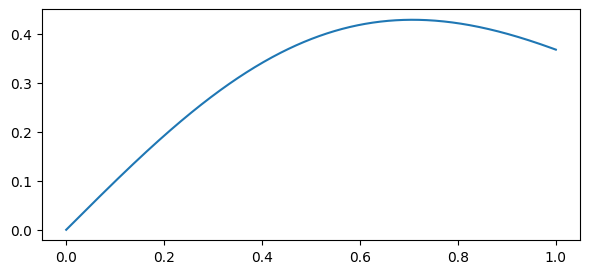

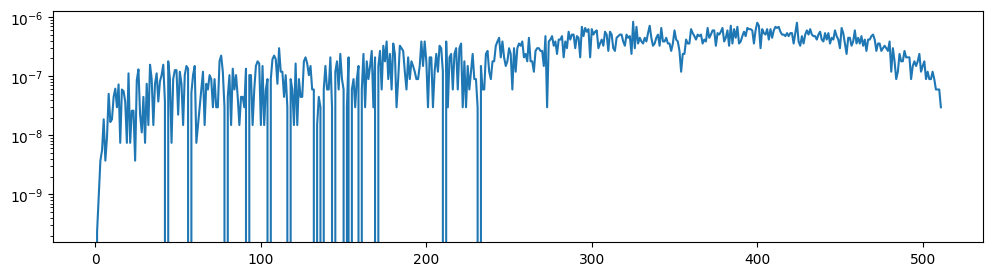

In [112]:
u_pred = model.predict(X)

error = jnp.abs(u_solution - u_pred)
rel_l2_error = jnp.linalg.norm(error) / jnp.linalg.norm(u_solution)

print(f"Relative L2 Error: {rel_l2_error:.3e}")

fig, ax = plt.subplots(figsize=(8, 3))
ax.set_aspect("equal")
nn_solution = ax.plot(X, u_pred)
plt.show()

fig, ax = plt.subplots(figsize=(12, 3))
nn_error = ax.plot(error)
# ax.set_aspect("equal")
ax.set_yscale("log")
plt.show()


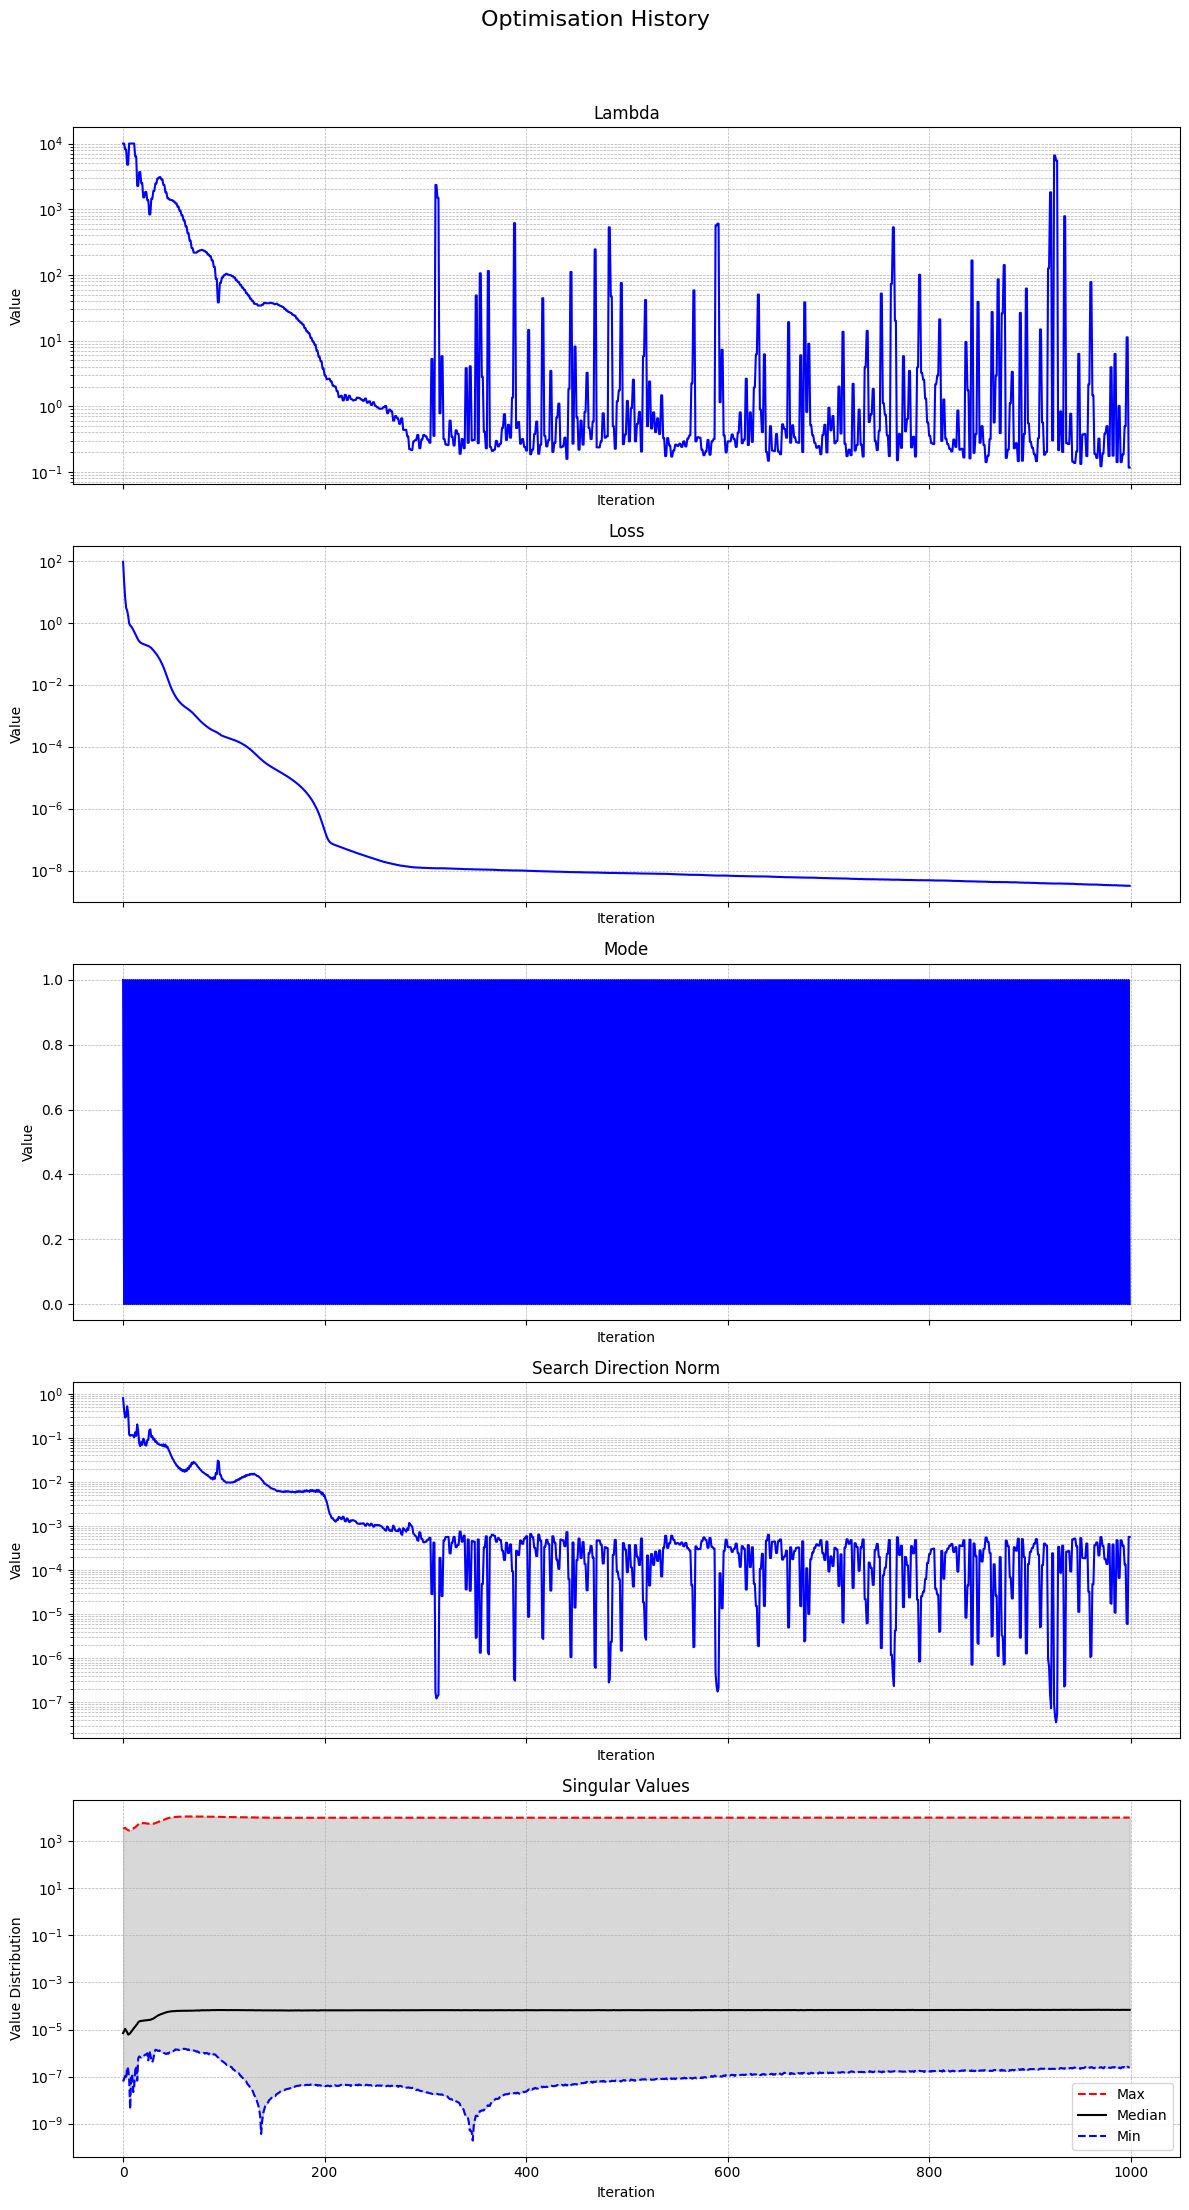

In [113]:
history.plot()